# Learning objective

This notebook illustrates the dynamics of solitary waves in granular chains with particle-particle contact. Examples and parameters are adapted from the [milestone paper](https://journals.aps.org/pre/collections/pre-milestones) by Coste, Falcon & Fauve in [_Physical Review E_](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.56.6104). Comparisons are made to [Nesterenko's continuum theory](https://link.springer.com/book/10.1007%2F978-1-4757-3524-6).

# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from scipy.interpolate import griddata
from scipy import optimize

# to save plots as files and download them
#from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# The granular chain

The governing equation of the displacement of the $j$th particle ("grain") in a chain of identical spherical particles in Hertzian contact obeys
$$ m \ddot{u}_j = \frac{\sqrt{a/2}}{2\theta}\left\{ [\Delta_0 - (u_j - u_{j-1})]^{3/2} - [\Delta_0 - (u_{j+1} - u_j)]^{3/2} \right\}, \quad j=1,\dots,N-2, $$
where
*   $\Delta_0=2(\theta F_0)^{2/3}/a^{1/3}$ is the _pre-compession_ (same for all particles, caused by the static force $F_0\in[0,170]$ N),
*   $m = 4\pi\rho a^3/3$ is the _mass_ of each particle with radius $a \approx 4$ mm and of density $\rho = 7650$ kg/m$^3$,
*   $\theta = 3(1-\nu^2)/(4E) = 3.02\times10^{-12}$ m$^2$/N is a parameter related to the Hertzian force law (Poisson ratio $\nu=0.3$ and Young's modulus $E=2.26\times10^{11}$ N/m$^2$).

The values were obtained from Table 1 of Coste _et al._, corresponding to steel particles. The equations of motion for spheres $j=0$ and $j=N-1$ come from specifying boundary conditions.

In [2]:
# physical parameters (SI units)
rho = 7650
a = 4e-3
m = 4*np.pi*a**3*rho/3
nu = 0.3
E = 2.26e11
theta = 3*(1-nu**2)/(4*E)
F0 = 0
delta0 = 2*(theta*F0)**(2/3)/a**(1/3)
print(f'delta0 = {delta0:.3E}')

# to be used in ODE
rhs_coeff = np.sqrt(a/2)/(2*m*theta)

# number of particles ("grains")
N = 51

delta0 = 0.000E+00


## The solitary-wave solution

Nesterenko found an unusual traveling-wave solution in the long-wave limit ($a\ll L$) with no precompression ($\Delta_0=0$):
$$ -u_x(x,t) = \left(\frac{5}{4}\frac{V^2}{\mathcal{C}^2}\right)^2\left[ \cos^4\left(\frac{x-x_0-Vt}{a\sqrt{10}}\right)\right]_+,$$
where $\mathcal{C}=\sqrt{2a^3/(m\theta)}$ is a nonlinear "sound speed" (check the units), $V$ is the phase speed of the traveling wave.

Immediately, we observe that this solution goes to $0$ at $x=\pm ...$ and remains zero for bigger $|x|$. Very unusual! This is called a [compacton](http://www.ams.org/notices/200507/what-is.pdf).

In [3]:
# the compacton -u_x, r0 = a is the radius of spheres
def soli_x(x,t,x0,Vs,Cs,r0):
  y = (x-x0-Vs*t)/(r0*np.sqrt(10))
  ux = (5/4*Vs**2/Cs**2)**2*np.cos(y)**4
  ux[y<-np.pi/2] = 0
  ux[y>np.pi/2] = 0
  return ux

Observe that, as in all our nonlinear wave solitary wave examples, the amplitude of the wave depends on its speed $V$. Inverting this relationship, the maximum strain $\max(-u_x)$ is the amplitude, and $V = (4/5)^{1/2}\mathcal{C}[\max(-u_x)]^{1/4}$, Taking the amplitude of the solitary wave, `5e-6` m, according to the example simulation below, we can estimate $V$.

In [20]:
C = np.sqrt(2*a**3/(m*theta))
V = np.sqrt(4/5)*C*(5e-6)**(1/4)
print(V)

192.278339039569


However, this is not quite accurate as we generate the solitary wave by an impact on the left end of the chain. So we should use Eq. (24), $V= \sqrt{4/5} (2 \theta F_m/a^2)^{1/6} \mathcal{C}$, of Conte _et al._ based on the maxium force $F_m$ (and $\Delta_0=0$).

In [5]:
Fm = 50 # from the force contour plot
V = C*(4/5)**(1/2)*(2*theta*Fm/a**2)**(1/6)
print(V)

663.4887546255898


To plot the solitary wave's shape, we need a continuous domain, which I take to be $L=100a$ to ensure a continuum limit. I place the center of the wave at $x_0=L/2$.

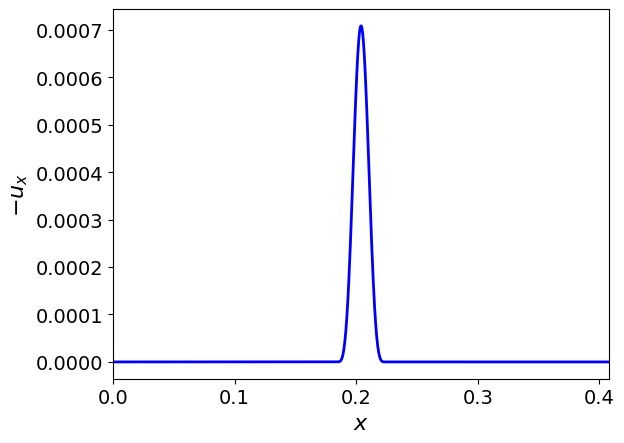

In [6]:
L = N*(2*a)
xj = np.linspace(0,L,num=1000)
uxj = soli_x(xj,0,L/2,V,C,a)

fig, ax = plt.subplots()
ax.plot(xj, uxj, color='blue', linewidth=2)
#ax.set_ylim(-1.1,2.1)
ax.set_ylabel('$-u_x$')
ax.set_xlim(0,L)
ax.set_xlabel('$x$');

In [7]:
# width of the solitary wave
# as a multiple of paticle diameter
2 * (np.pi/2*a*np.sqrt(10)) / (a*2)

4.967294132898051

In [8]:
# TODO: implement u from u_x ...

## The initial condition

The initial condition is zero displacements.

In [9]:
# set an initial condition for displacement
uic = np.zeros(N)

Then, the chain is impacted on the left end (position $j=0$) at $t=0$. The impact occurs instanteneously here and generates an initial velocity of $\approx 0.5$ m/s for the first particle. The remaining particles are at rest, initially.

In [10]:
# set an initial condition for velocity
vic = np.zeros(N)
vic[0] = 0.5
#vic[-1] = -0.5

# concatenate the two ICs for later use as one vector
uvic = np.concatenate((uic,vic))

# Numerical solution

As usual, we rewrite the second-order problem as a first-order semi-discrete system:
$$\left\{ \begin{align}\dot{u}_j &= v_j,\\ \dot{v}_j &= \frac{\sqrt{a/2}}{2m\theta}\left\{ [\Delta_0 - (u_j - u_{j-1})]_+^{3/2} - [\Delta_0 - (u_{j+1} - u_j)]_+^{3/2} \right\}, \quad j=1,\dots,N-2, \end{align} \right.$$

In the above right-hand side, we have used the $[\cdot]_+$ function,
$$ [\xi]_+ = \begin{cases} \xi, &\xi>0,\\ 0, &\text{else}, \end{cases}$$
to ensure that if particles lose contact, then they experience no force (and we don't plug in negative numbers into a fractional power...).

The boundary condition at the left end is implemented as in Eq. (6) of [Theocharis _et al._](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.82.056604). At the right end, we simply have an immovable wall.


In [11]:
# ODE system right-hand side
def gran_chain(t,u):
  F = np.empty(2*N)

  # boundary nodes require special care
  F[0] = u[N]
  F[N-1] = u[2*N-1]
  # the first sphere (j=0) has no overlaps (u[-1]=u[0]),
  # but it is constrained to maintain the pre-compression force F0
  F[N] = F0/m + rhs_coeff*( max(delta0-(u[0]-u[0]),0)**(3/2) \
                            - max(delta0-(u[1]-u[0]),0)**(3/2) )
  # beyond the (N-1)st particle is a wall, it has 0 displacement,
  # which ensures reflection of the pulse from this wall
  F[2*N-1] = rhs_coeff*( max(delta0-(u[N-1]-u[N-2]),0)**(3/2) \
                         - max(delta0-(0-u[N-1]),0)**(3/2) )

  # or, handle it like the first sphere,
  # if we're 'hitting' the chain on both ends
  #F[2*N-1] = rhs_coeff*( max(delta0-(u[N-1]-u[N-2]),0)**(3/2) \
  #                       - max(delta0-(u[N-1]-u[N-1]),0)**(3/2) ) - F0/m

  # interior nodes, per the ODE formula
  for j in range(1,N-1):
    F[j]   = u[j+N]
    F[j+N] = rhs_coeff*( max(delta0-(u[j]-u[j-1]),0)**(3/2) \
                          - max(delta0-(u[j+1]-u[j]),0)**(3/2) )
  return F

In [12]:
# total simulation (dimensional, in sec)
tmax = 1.2e-3

# try: test different tolerances for the integrator, changing reltol
reltol = 1e-6

We use SciPy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to numerically integrate the system of $2N$ ODEs forward in time. In this field, people seem to use `RK45`, so do we.

In [13]:
# find the time evolution of the particle displacements
sol = solve_ivp(fun=gran_chain,
                t_span=[0,tmax], y0=uvic,
                method='RK45', rtol=reltol, dense_output=True)

# Results and visualization

First, just a quick static plot of the solution at the final time.

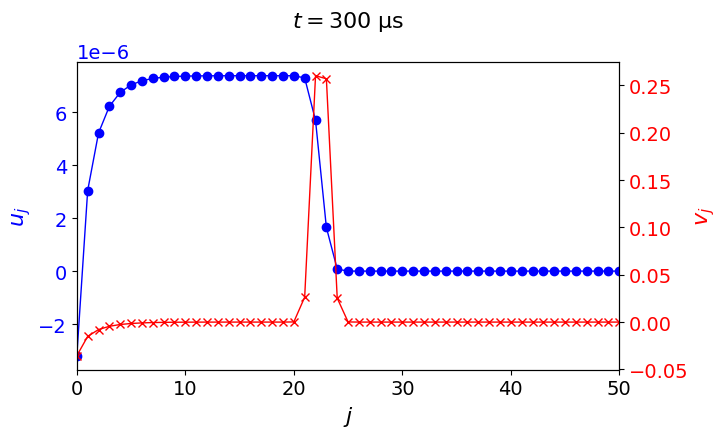

In [14]:
tplot = tmax/4
xj = range(0,N)
uj = sol.sol(tplot)[0:N]
vj = sol.sol(tplot)[N:2*N]

fig, ax1 = plt.subplots(figsize=(7,4))

# displacements on the left axis
ax1.plot(xj, uj, linewidth=1, marker='o', color='blue')
ax1.set_ylabel('$u_j$', color='blue')
ax1.set_xlabel('$j$')
ax1.set_xlim(0,N-1)
ax1.tick_params(axis='y', labelcolor='blue')

# velocities on the right axis
ax2 = ax1.twinx()
ax2.plot(xj, vj, linewidth=1, marker='x', color='red')
#ax2.set_ylim(-0.1,0.1)
ax2.set_ylabel('$v_j$', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title(f'$t=${tplot*1e6:.0f} μs');

## Space-time plot

In [21]:
# define how to sample the solution in time
tnum = N+1
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

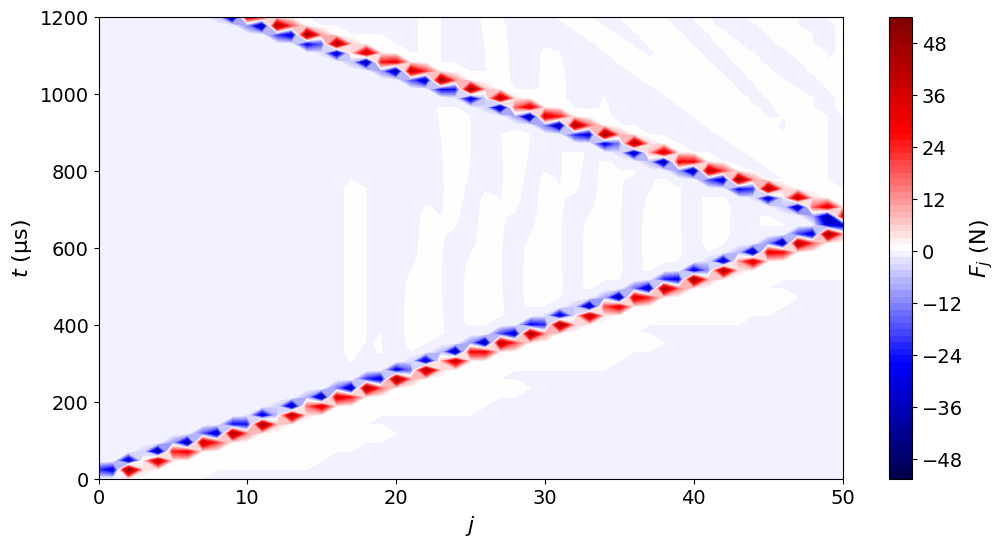

In [22]:
# make a matrix of space-time values {u_j(t)}
Fjp = np.empty((tnum,N))
for it in range(0,tnum):
  tmp = sol.sol(it*dt)
  ajp = gran_chain(it*dt,tmp)[N:2*N]
  Fjp[it,:] = m*ajp

# make cool plot, try also cmap='RdGy'
fig, ax = plt.subplots(figsize=(12, 6))
plt.contourf(xj, tspan*1e6, Fjp, 100, cmap='seismic')
plt.colorbar(label='$F_j$ (N)')
ax.set_ylim(0,tmax*1e6)
ax.set_ylabel('$t$ (μs)')
ax.set_xlim(0,N-1)
ax.set_xlabel('$j$');

As a back-of-the-envelope check, from the contour plot, we estimate $V = (50 \times 2 \times 4 ~\text{mm})/(620~μ\text{s}) \approx 645 ~\text{m/s}$. While, from Eq. (24) of Conte _et al._, based on the continuum theory, we got $V\approx 663$ m/s above. Not bad!

## Animation

Animation to show the solitary wave in the strain field $-u_j'$.

In [17]:
# define how to sample the solution in time
tnum = 200
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [18]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$-u_j\'$')
ax.set_xlabel('$j$')
ax.set_xlim(0,N-1)
ax.set_ylim(-1e-5,1e-5)
# nice dynamic label to show time
ttl = ax.text(0.05, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
ax.plot(xj, np.zeros(N), linestyle="dashed", linewidth=1, color='black')
line, = ax.plot(xj, np.zeros(N), color='blue', linewidth=1, marker='o')

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol.sol(it*dt)[0:N]

  uxj = np.empty(N)
  uxj[0] = (uj[1] - 0)/(2*1)
  uxj[1:N-1] = (uj[2:N] - uj[0:N-2])/(2*1)
  uxj[N-1] = (0 - uj[N-2])/(2*1)

  line.set_data(xj, -uxj)
  ttl.set_text(f'$t=${it*dt*1e6:.0f} μs');

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.